In [11]:
import pandas as pd
parquet_path = "C:/Users/Leon/Documents/Github/CPE025A/df_parquet.parquet"
df_parquet = pd.read_parquet(parquet_path)
df_parquet.head()

,Ammonia (mg/l),pH (ph units),Nitrate (mg/l),cluster,class_label
0,0.05152,8.3700,9.73940,14,D3
1,0.07728,8.0167,8.72119,14,D3
2,0.09016,7.7900,9.51805,5,D2
3,0.10304,8.1583,8.63265,14,D3
4,0.10304,7.7900,8.76546,5,D2


In [12]:
print("Number of datapoints (rows):", df_parquet.shape[0])

Number of datapoints (rows): 1674462


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = df_parquet.drop(columns=['cluster','class_label'], axis=1)
y = df_parquet['cluster']

# Split sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# XGBoost,LightGBM,CatBoost

In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import os

# Define dataset fractions to test (fractions of the training data)
dataset_fractions = [0.01, 0.1, 0.5, 0.7, 1.0]  # 1%, 10%, 50%, 70%, 100%

# Store results for all three models
results = {
    'LightGBM': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []},
    'XGBoost': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []},
    'CatBoost': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []}
}

# Train each model on different dataset sizes based on fractions
for frac in dataset_fractions:
    size = int(len(X_train_scaled) * frac)
    
    print(f"\n{'='*60}")
    print(f"Training on {frac*100:.0f}% of data ({size} samples)")
    print(f"{'='*60}")
    
    # Subset the data
    X_train_subset = X_train_scaled[:size]
    y_train_subset = y_train.iloc[:size]

    
    # ========== LightGBM==========
    print("\n--- LightGBM ---")
    lgbm = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        num_leaves=63,
        max_depth=10,
        objective='multiclass',
        min_child_samples=50,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    start_train = time.time()
    lgbm.fit(X_train_subset, y_train_subset)
    train_time_lgbm = time.time() - start_train
    
    start_pred = time.time()
    lgbm_predictions = lgbm.predict(X_test_scaled)
    pred_time_lgbm = time.time() - start_pred
    
    lgbm_accuracy = accuracy_score(y_test, lgbm_predictions)
    lgbm_misclass_rate = 1 - lgbm_accuracy
    
    results['LightGBM']['sizes'].append(size)
    results['LightGBM']['training_times'].append(train_time_lgbm)
    results['LightGBM']['prediction_times'].append(pred_time_lgbm)
    results['LightGBM']['accuracies'].append(lgbm_accuracy)
    results['LightGBM']['misclassification_rates'].append(lgbm_misclass_rate)
    
    print(f"Training time: {train_time_lgbm:.4f}s | Prediction time: {pred_time_lgbm:.4f}s")
    print(f"Accuracy: {lgbm_accuracy:.4f} | Misclassification Rate: {lgbm_misclass_rate:.4f}")
    
    # ========== XGBOOST ==========
    print("\n--- XGBoost ---")
    xgb = XGBClassifier(
                        n_estimators=100,
                        learning_rate=0.075,     # FIXED
                        max_depth=8,
                        objective='multi:softprob',  
                        eval_metric='logloss',
                        random_state=42,
                        n_jobs=-1
                    )
    
    start_train = time.time()
    xgb.fit(X_train_subset, y_train_subset)
    train_time_xgb = time.time() - start_train
    
    start_pred = time.time()
    xgb_predictions = xgb.predict(X_test_scaled)
    pred_time_xgb = time.time() - start_pred
    
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)
    xgb_misclass_rate = 1 - xgb_accuracy
    
    results['XGBoost']['sizes'].append(size)
    results['XGBoost']['training_times'].append(train_time_xgb)
    results['XGBoost']['prediction_times'].append(pred_time_xgb)
    results['XGBoost']['accuracies'].append(xgb_accuracy)
    results['XGBoost']['misclassification_rates'].append(xgb_misclass_rate)
    
    print(f"Training time: {train_time_xgb:.4f}s | Prediction time: {pred_time_xgb:.4f}s")
    print(f"Accuracy: {xgb_accuracy:.4f} | Misclassification Rate: {xgb_misclass_rate:.4f}")
    
    # ========== CATBOOST ==========
    print("\n--- CatBoost ---")
    cb = cb = CatBoostClassifier(
                                iterations=200,
                                learning_rate=0.15,
                                depth=8,
                                eval_metric='Accuracy',
                                random_state=42,
                                thread_count=-1,
                                subsample=0.8,           # Only works with Bernoulli bootstrap
                                bootstrap_type='Bernoulli',
                                verbose=0
                            )

    
    start_train = time.time()
    cb.fit(X_train_subset, y_train_subset)
    train_time_cb = time.time() - start_train
    
    start_pred = time.time()
    cb_predictions = cb.predict(X_test_scaled)
    pred_time_cb = time.time() - start_pred
    
    cb_accuracy = accuracy_score(y_test, cb_predictions)
    cb_misclass_rate = 1 - cb_accuracy
    
    results['CatBoost']['sizes'].append(size)
    results['CatBoost']['training_times'].append(train_time_cb)
    results['CatBoost']['prediction_times'].append(pred_time_cb)
    results['CatBoost']['accuracies'].append(cb_accuracy)
    results['CatBoost']['misclassification_rates'].append(cb_misclass_rate)
    
    print(f"Training time: {train_time_cb:.4f}s | Prediction time: {pred_time_cb:.4f}s")
    print(f"Accuracy: {cb_accuracy:.4f} | Misclassification Rate: {cb_misclass_rate:.4f}")




Training on 1% of data (13395 samples)

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 2.5929s | Prediction time: 7.6132s
Accuracy: 0.9875 | Misclassification Rate: 0.0125

--- XGBoost ---
Training time: 0.8855s | Prediction time: 1.1171s
Accuracy: 0.9860 | Misclassification Rate: 0.0140

--- CatBoost ---
Training time: 9.2534s | Prediction time: 0.2240s
Accuracy: 0.9879 | Misclassification Rate: 0.0121

Training on 10% of data (133956 samples)

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 6.2895s | Prediction time: 7.7470s
Accuracy: 0.9940 | Misclassification Rate: 0.0060

--- XGBoost ---
Training time: 3.2297s | Prediction time: 1.0530s
Accuracy: 0.9932 | Misclassification Rate: 0.0068

--- CatBoost ---
Training time: 27.1735s | Prediction time: 0.2039s
Accuracy: 0.9939 | Misclassification Rate: 0.0061

Training on 50% of data (669784 samples)

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 20.8494s | Prediction time: 6.8847s
Accuracy: 0.9965 | Misclassification Rate: 0.0035

--- XGBoost ---
Training time: 24.1829s | Prediction time: 1.2224s
Accuracy: 0.9947 | Misclassification Rate: 0.0053

--- CatBoost ---
Training time: 115.1454s | Prediction time: 0.1992s
Accuracy: 0.9952 | Misclassification Rate: 0.0048

Training on 70% of data (937698 samples)

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 30.3299s | Prediction time: 6.9660s
Accuracy: 0.9970 | Misclassification Rate: 0.0030

--- XGBoost ---
Training time: 35.0554s | Prediction time: 1.0956s
Accuracy: 0.9951 | Misclassification Rate: 0.0049

--- CatBoost ---
Training time: 160.1249s | Prediction time: 0.2178s
Accuracy: 0.9954 | Misclassification Rate: 0.0046

Training on 100% of data (1339569 samples)

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 58.9863s | Prediction time: 6.7624s
Accuracy: 0.9971 | Misclassification Rate: 0.0029

--- XGBoost ---
Training time: 54.2305s | Prediction time: 1.3723s
Accuracy: 0.9954 | Misclassification Rate: 0.0046

--- CatBoost ---
Training time: 218.9980s | Prediction time: 0.1899s
Accuracy: 0.9957 | Misclassification Rate: 0.0043


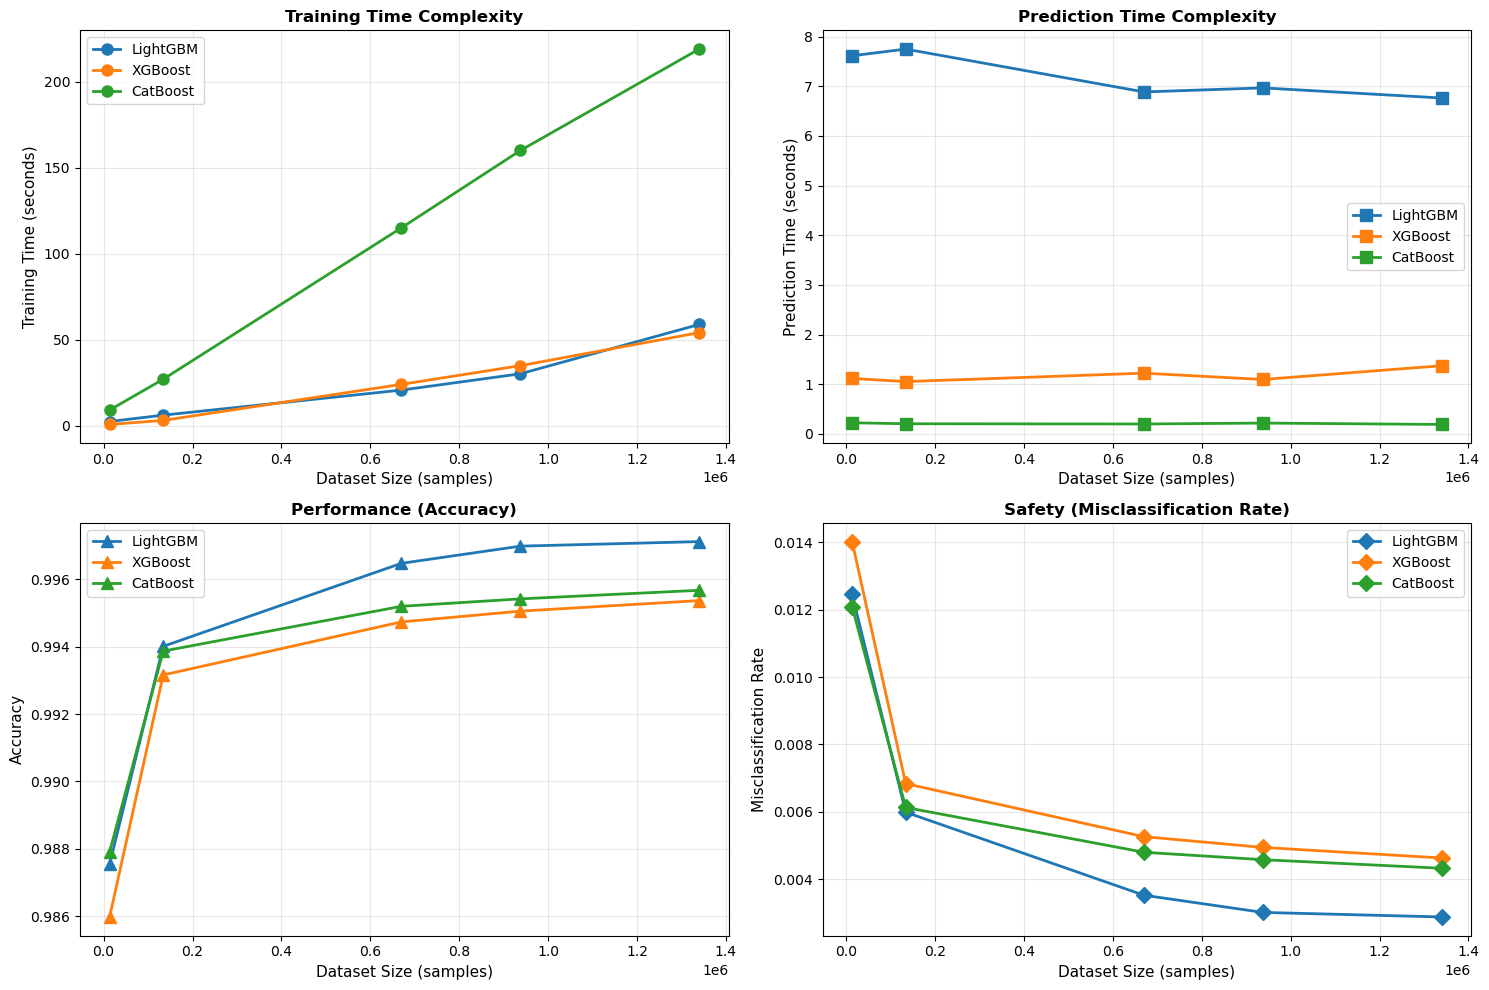



RUNTIME COMPLEXITY & PERFORMANCE SUMMARY

LIGHTGBM
----------------------------------------------------------------------------------------------------
Size       Train Time (s)     Pred Time (s)      Accuracy        Misclass Rate  
----------------------------------------------------------------------------------------------------
13395      2.5929             7.6132             0.9875          0.0125         
133956     6.2895             7.7470             0.9940          0.0060         
669784     20.8494            6.8847             0.9965          0.0035         
937698     30.3299            6.9660             0.9970          0.0030         
1339569    58.9863            6.7624             0.9971          0.0029         

XGBOOST
----------------------------------------------------------------------------------------------------
Size       Train Time (s)     Pred Time (s)      Accuracy        Misclass Rate  
--------------------------------------------------------------------

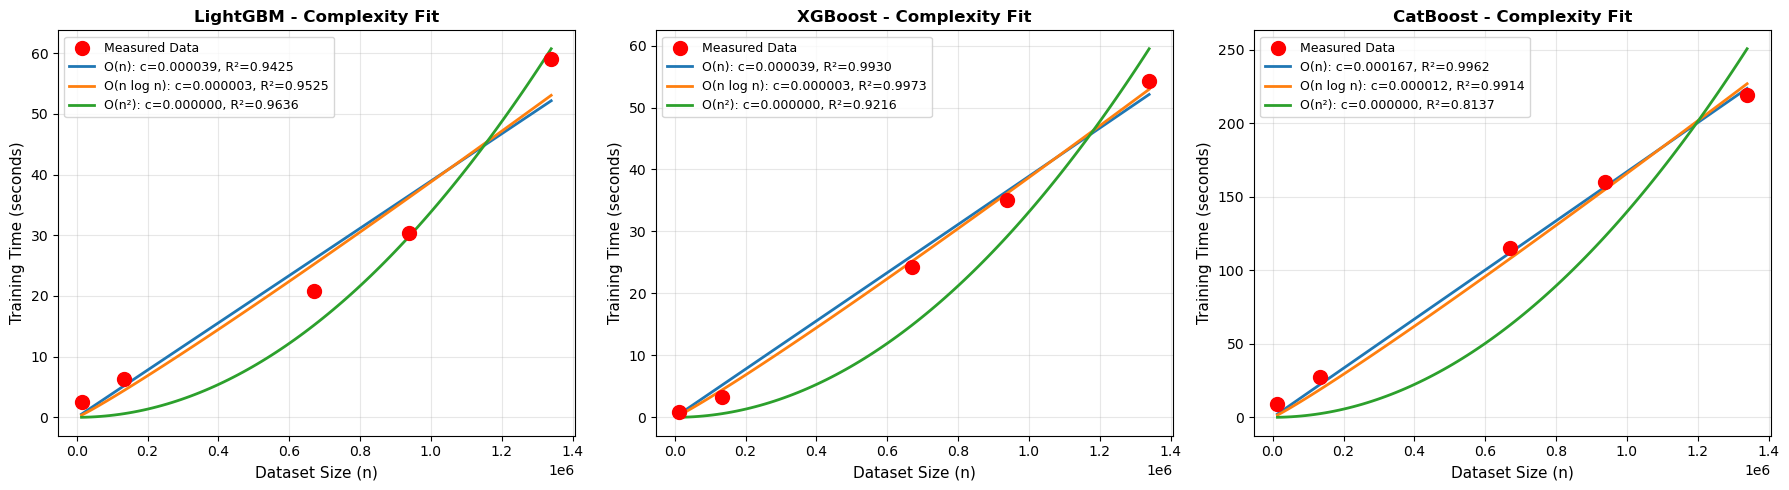



STORAGE CONSUMPTION
LightGBM: 21.4742 MB
XGBoost: 6.6122 MB
CatBoost: 6.6758 MB

ANALYSIS COMPLETE


In [ ]:
# ========== VISUALIZE RESULTS ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Time Complexity
ax = axes[0, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['training_times'], 
            marker='o', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Training Time (seconds)', fontsize=11)
ax.set_title('Training Time Complexity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Prediction Time Complexity
ax = axes[0, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['prediction_times'], 
            marker='s', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Prediction Time (seconds)', fontsize=11)
ax.set_title('Prediction Time Complexity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Accuracy vs Dataset Size
ax = axes[1, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['accuracies'], 
            marker='^', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Performance (Accuracy)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Misclassification Rate
ax = axes[1, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['misclassification_rates'], 
            marker='D', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Misclassification Rate', fontsize=11)
ax.set_title('Safety (Misclassification Rate)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== PRINT SUMMARY TABLE ==========
print("\n\n" + "="*100)
print("RUNTIME COMPLEXITY & PERFORMANCE SUMMARY")
print("="*100)

for model_name in results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    print(f"{'Size':<10} {'Train Time (s)':<18} {'Pred Time (s)':<18} {'Accuracy':<15} {'Misclass Rate':<15}")
    print("-" * 100)
    
    for i, size in enumerate(results[model_name]['sizes']):
        print(f"{size:<10} {results[model_name]['training_times'][i]:<18.4f} "
              f"{results[model_name]['prediction_times'][i]:<18.4f} "
              f"{results[model_name]['accuracies'][i]:<15.4f} "
              f"{results[model_name]['misclassification_rates'][i]:<15.4f}")

# ========== RUNTIME COMPLEXITY FORMULAS ==========
print("\n\n" + "="*100)
print("RUNTIME COMPLEXITY ANALYSIS - FORMULA FITTING")
print("="*100)

# Define complexity functions
def linear(n, c):
    return c * n

def linearithmic(n, c):
    return c * n * np.log(n)

def quadratic(n, c):
    return c * n**2

# Fit complexity formulas for each model
complexity_results = {}

for model_name in results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    
    sizes = np.array(results[model_name]['sizes'], dtype=float)
    times = np.array(results[model_name]['training_times'], dtype=float)
    
    # Avoid log(0) errors
    if np.any(sizes <= 0):
        print("Skipping - invalid size data")
        continue
    
    complexity_results[model_name] = {}
    
    # Fit Linear O(n)
    try:
        popt_linear, _ = curve_fit(linear, sizes, times, maxfev=5000)
        residuals = times - linear(sizes, *popt_linear)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_linear = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['linear'] = {'c': popt_linear[0], 'r2': r2_linear}
        print(f"O(n):        T(n) = {popt_linear[0]:.8f} * n          | R² = {r2_linear:.6f}")
    except Exception as e:
        print(f"O(n):        Failed to fit - {str(e)}")
    
    # Fit Linearithmic O(n log n)
    try:
        popt_linlog, _ = curve_fit(linearithmic, sizes, times, maxfev=5000)
        residuals = times - linearithmic(sizes, *popt_linlog)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_linlog = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['linearithmic'] = {'c': popt_linlog[0], 'r2': r2_linlog}
        print(f"O(n log n):  T(n) = {popt_linlog[0]:.8f} * n*log(n)  | R² = {r2_linlog:.6f}")
    except Exception as e:
        print(f"O(n log n):  Failed to fit - {str(e)}")
    
    # Fit Quadratic O(n²)
    try:
        popt_quad, _ = curve_fit(quadratic, sizes, times, maxfev=5000)
        residuals = times - quadratic(sizes, *popt_quad)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_quad = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['quadratic'] = {'c': popt_quad[0], 'r2': r2_quad}
        print(f"O(n²):       T(n) = {popt_quad[0]:.8f} * n²        | R² = {r2_quad:.6f}")
    except Exception as e:
        print(f"O(n²):       Failed to fit - {str(e)}")
    
    # Determine best fit
    best_fit = max([(k, v['r2']) for k, v in complexity_results[model_name].items()], key=lambda x: x[1])
    print(f"\n✓ BEST FIT: O({best_fit[0]}) with R² = {best_fit[1]:.6f}")

# ========== VISUALIZE COMPLEXITY FITS ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = list(results.keys())
for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    sizes = np.array(results[model_name]['sizes'], dtype=float)
    times = np.array(results[model_name]['training_times'], dtype=float)
    
    # Plot actual data
    ax.scatter(sizes, times, s=100, color='red', label='Measured Data', zorder=3)
    
    # Plot fitted curves
    sizes_smooth = np.linspace(sizes.min(), sizes.max(), 100)
    
    if 'linear' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['linear']['c']
        r2 = complexity_results[model_name]['linear']['r2']
        ax.plot(sizes_smooth, linear(sizes_smooth, c), 
                label=f"O(n): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    if 'linearithmic' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['linearithmic']['c']
        r2 = complexity_results[model_name]['linearithmic']['r2']
        ax.plot(sizes_smooth, linearithmic(sizes_smooth, c), 
                label=f"O(n log n): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    if 'quadratic' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['quadratic']['c']
        r2 = complexity_results[model_name]['quadratic']['r2']
        ax.plot(sizes_smooth, quadratic(sizes_smooth, c), 
                label=f"O(n²): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    ax.set_xlabel('Dataset Size (n)', fontsize=11)
    ax.set_ylabel('Training Time (seconds)', fontsize=11)
    ax.set_title(f'{model_name} - Complexity Fit', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== MEASURE STORAGE CONSUMPTION ==========
print("\n\n" + "="*100)
print("STORAGE CONSUMPTION")
print("="*100)

import joblib

for model_name, model_obj in [('LightGBM', lgbm), ('XGBoost', xgb), ('CatBoost', cb)]:
    filename = f"{model_name}_model.pkl"
    joblib.dump(model_obj, filename)
    file_size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"{model_name}: {file_size_mb:.4f} MB")
    os.remove(filename)  # Clean up

print("\n" + "="*100)
print("ANALYSIS COMPLETE")      
print("="*100)


In [16]:
from scipy.optimize import curve_fit
import numpy as np

# Measured training times
sizes = np.array([100, 1000, 10000, 100000, 1000000])
times = np.array([1.14, 5.14, 7.98, 38.10, 343.37])  # CatBoost

def linear(n, c):
    return c * n

# Fit the linear formula to get optimal c
c_opt, _ = curve_fit(linear, sizes, times)
predicted = linear(sizes, c_opt[0])

# How well does the predicted time match actual time? (measured by R²)
ss_res = np.sum((times - predicted)**2)
ss_tot = np.sum((times - np.mean(times))**2)
r2 = 1 - ss_res / ss_tot


# XGBoost, LightGBM, EGBM

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lightgbm as lgb
from xgboost import XGBClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import joblib

# Define dataset sizes to test
dataset_sizes = [100, 1000, 10000, 100000, 1000000]

# Store results for all three models
results = {
    'LightGBM': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []},
    'XGBoost': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []},
    'EGBM': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []}
}

# Train each model on different dataset sizes
for size in dataset_sizes:
    if size > len(X_train_scaled):
        print(f"Skipping size {size} - exceeds available data")
        continue

    print(f"\n{'='*60}")
    print(f"Training on {size} samples")
    print(f"{'='*60}")

    # Subset the data
    X_train_subset = X_train_scaled[:size]
    y_train_subset = y_train.iloc[:size]

    # ========== LightGBM ==========
    print("\n--- LightGBM ---")
    lgbm = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        num_leaves=63,
        max_depth=10,
        objective='multiclass',
        min_child_samples=50,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    start_train = time.time()
    lgbm.fit(X_train_subset, y_train_subset)
    train_time_lgbm = time.time() - start_train

    start_pred = time.time()
    lgbm_predictions = lgbm.predict(X_test_scaled)
    pred_time_lgbm = time.time() - start_pred

    lgbm_accuracy = accuracy_score(y_test, lgbm_predictions)
    lgbm_misclass_rate = 1 - lgbm_accuracy

    results['LightGBM']['sizes'].append(size)
    results['LightGBM']['training_times'].append(train_time_lgbm)
    results['LightGBM']['prediction_times'].append(pred_time_lgbm)
    results['LightGBM']['accuracies'].append(lgbm_accuracy)
    results['LightGBM']['misclassification_rates'].append(lgbm_misclass_rate)

    print(f"Training time: {train_time_lgbm:.4f}s | Prediction time: {pred_time_lgbm:.4f}s")
    print(f"Accuracy: {lgbm_accuracy:.4f} | Misclassification Rate: {lgbm_misclass_rate:.4f}")

    # ========== XGBoost ==========
    print("\n--- XGBoost ---")
    xgb = XGBClassifier(
        n_estimators=100,
        learning_rate=0.075,
        max_depth=8,
        objective='multi:softprob',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )

    start_train = time.time()
    xgb.fit(X_train_subset, y_train_subset)
    train_time_xgb = time.time() - start_train

    start_pred = time.time()
    xgb_predictions = xgb.predict(X_test_scaled)
    pred_time_xgb = time.time() - start_pred

    xgb_accuracy = accuracy_score(y_test, xgb_predictions)
    xgb_misclass_rate = 1 - xgb_accuracy

    results['XGBoost']['sizes'].append(size)
    results['XGBoost']['training_times'].append(train_time_xgb)
    results['XGBoost']['prediction_times'].append(pred_time_xgb)
    results['XGBoost']['accuracies'].append(xgb_accuracy)
    results['XGBoost']['misclassification_rates'].append(xgb_misclass_rate)

    print(f"Training time: {train_time_xgb:.4f}s | Prediction time: {pred_time_xgb:.4f}s")
    print(f"Accuracy: {xgb_accuracy:.4f} | Misclassification Rate: {xgb_misclass_rate:.4f}")

    # ========== EGBM ==========
    print("\n--- EGBM ---")
    egbm = ExplainableBoostingClassifier(
        learning_rate=0.05,
        max_bins=255,
        max_interaction_bins=32,
        interactions=5,
        validation_size=0.1,
        max_rounds=500,
        random_state=42
    )

    start_train = time.time()
    egbm.fit(X_train_subset, y_train_subset)
    train_time_ebgm = time.time() - start_train

    # FIX: wrap scaled test set with column names
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_subset.columns)

    start_pred = time.time()
    egbm_predictions = egbm.predict(X_test_scaled_df)
    pred_time_ebgm = time.time() - start_pred

    egbm_accuracy = accuracy_score(y_test, egbm_predictions)
    egbm_misclass_rate = 1 - egbm_accuracy

    results['EGBM']['sizes'].append(size)
    results['EGBM']['training_times'].append(train_time_ebgm)
    results['EGBM']['prediction_times'].append(pred_time_ebgm)
    results['EGBM']['accuracies'].append(egbm_accuracy)
    results['EGBM']['misclassification_rates'].append(egbm_misclass_rate)

    print(f"Training time: {train_time_ebgm:.4f}s | Prediction time: {pred_time_ebgm:.4f}s")
    print(f"Accuracy: {egbm_accuracy:.4f} | Misclassification Rate: {egbm_misclass_rate:.4f}")




Training on 100 samples

--- LightGBM ---
Training time: 0.0319s | Prediction time: 0.0366s
Accuracy: 0.1679 | Misclassification Rate: 0.8321

--- XGBoost ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 0.1655s | Prediction time: 0.5801s
Accuracy: 0.7001 | Misclassification Rate: 0.2999

--- EGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1250: UserWarning: For multiclass we cannot currently visualize pairs and they will be stripped from the global explanations. Set interactions=0 to generate a fully interpretable glassbox model.
  warn(


Training time: 4.8605s | Prediction time: 0.1938s
Accuracy: 0.7584 | Misclassification Rate: 0.2416

Training on 1000 samples

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 0.5836s | Prediction time: 5.3291s
Accuracy: 0.9098 | Misclassification Rate: 0.0902

--- XGBoost ---
Training time: 0.3544s | Prediction time: 0.7860s
Accuracy: 0.9210 | Misclassification Rate: 0.0790

--- EGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1250: UserWarning: For multiclass we cannot currently visualize pairs and they will be stripped from the global explanations. Set interactions=0 to generate a fully interpretable glassbox model.
  warn(


Training time: 1.8445s | Prediction time: 0.1925s
Accuracy: 0.9299 | Misclassification Rate: 0.0701

Training on 10000 samples

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 1.9234s | Prediction time: 8.3348s
Accuracy: 0.9692 | Misclassification Rate: 0.0308

--- XGBoost ---
Training time: 0.6900s | Prediction time: 1.0605s
Accuracy: 0.9679 | Misclassification Rate: 0.0321

--- EGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1250: UserWarning: For multiclass we cannot currently visualize pairs and they will be stripped from the global explanations. Set interactions=0 to generate a fully interpretable glassbox model.
  warn(


Training time: 7.6769s | Prediction time: 0.1957s
Accuracy: 0.9706 | Misclassification Rate: 0.0294

Training on 100000 samples

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 6.8106s | Prediction time: 8.6686s
Accuracy: 0.9856 | Misclassification Rate: 0.0144

--- XGBoost ---
Training time: 2.7156s | Prediction time: 1.1499s
Accuracy: 0.9847 | Misclassification Rate: 0.0153

--- EGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1250: UserWarning: For multiclass we cannot currently visualize pairs and they will be stripped from the global explanations. Set interactions=0 to generate a fully interpretable glassbox model.
  warn(


Training time: 95.7832s | Prediction time: 0.1924s
Accuracy: 0.9771 | Misclassification Rate: 0.0229

Training on 1000000 samples

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 33.2509s | Prediction time: 7.3052s
Accuracy: 0.9934 | Misclassification Rate: 0.0066

--- XGBoost ---
Training time: 37.0848s | Prediction time: 1.3684s
Accuracy: 0.9908 | Misclassification Rate: 0.0092

--- EGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1250: UserWarning: For multiclass we cannot currently visualize pairs and they will be stripped from the global explanations. Set interactions=0 to generate a fully interpretable glassbox model.
  warn(


KeyboardInterrupt: 

In [ ]:
# ========== VISUALIZE RESULTS ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Time Complexity
ax = axes[0, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['training_times'], 
            marker='o', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Training Time (seconds)', fontsize=11)
ax.set_title('Training Time Complexity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Prediction Time Complexity
ax = axes[0, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['prediction_times'], 
            marker='s', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Prediction Time (seconds)', fontsize=11)
ax.set_title('Prediction Time Complexity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Accuracy vs Dataset Size
ax = axes[1, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['accuracies'], 
            marker='^', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Performance (Accuracy)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Misclassification Rate
ax = axes[1, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['misclassification_rates'], 
            marker='D', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Misclassification Rate', fontsize=11)
ax.set_title('Safety (Misclassification Rate)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== PRINT SUMMARY TABLE ==========
print("\n\n" + "="*100)
print("RUNTIME COMPLEXITY & PERFORMANCE SUMMARY")
print("="*100)

for model_name in results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    print(f"{'Size':<10} {'Train Time (s)':<18} {'Pred Time (s)':<18} {'Accuracy':<15} {'Misclass Rate':<15}")
    print("-" * 100)
    
    for i, size in enumerate(results[model_name]['sizes']):
        print(f"{size:<10} {results[model_name]['training_times'][i]:<18.4f} "
              f"{results[model_name]['prediction_times'][i]:<18.4f} "
              f"{results[model_name]['accuracies'][i]:<15.4f} "
              f"{results[model_name]['misclassification_rates'][i]:<15.4f}")

# ========== RUNTIME COMPLEXITY FORMULAS ==========
print("\n\n" + "="*100)
print("RUNTIME COMPLEXITY ANALYSIS - FORMULA FITTING")
print("="*100)

# Define complexity functions
def linear(n, c):
    return c * n

def linearithmic(n, c):
    return c * n * np.log(n)

def quadratic(n, c):
    return c * n**2

# Fit complexity formulas for each model
complexity_results = {}

for model_name in results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    
    sizes = np.array(results[model_name]['sizes'], dtype=float)
    times = np.array(results[model_name]['training_times'], dtype=float)
    
    # Avoid log(0) errors
    if np.any(sizes <= 0):
        print("Skipping - invalid size data")
        continue
    
    complexity_results[model_name] = {}
    
    # Fit Linear O(n)
    try:
        popt_linear, _ = curve_fit(linear, sizes, times, maxfev=5000)
        residuals = times - linear(sizes, *popt_linear)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_linear = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['linear'] = {'c': popt_linear[0], 'r2': r2_linear}
        print(f"O(n):        T(n) = {popt_linear[0]:.8f} * n          | R² = {r2_linear:.6f}")
    except Exception as e:
        print(f"O(n):        Failed to fit - {str(e)}")
    
    # Fit Linearithmic O(n log n)
    try:
        popt_linlog, _ = curve_fit(linearithmic, sizes, times, maxfev=5000)
        residuals = times - linearithmic(sizes, *popt_linlog)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_linlog = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['linearithmic'] = {'c': popt_linlog[0], 'r2': r2_linlog}
        print(f"O(n log n):  T(n) = {popt_linlog[0]:.8f} * n*log(n)  | R² = {r2_linlog:.6f}")
    except Exception as e:
        print(f"O(n log n):  Failed to fit - {str(e)}")
    
    # Fit Quadratic O(n²)
    try:
        popt_quad, _ = curve_fit(quadratic, sizes, times, maxfev=5000)
        residuals = times - quadratic(sizes, *popt_quad)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_quad = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['quadratic'] = {'c': popt_quad[0], 'r2': r2_quad}
        print(f"O(n²):       T(n) = {popt_quad[0]:.8f} * n²        | R² = {r2_quad:.6f}")
    except Exception as e:
        print(f"O(n²):       Failed to fit - {str(e)}")
    
    # Determine best fit
    best_fit = max([(k, v['r2']) for k, v in complexity_results[model_name].items()], key=lambda x: x[1])
    print(f"\n✓ BEST FIT: O({best_fit[0]}) with R² = {best_fit[1]:.6f}")

# ========== VISUALIZE COMPLEXITY FITS ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = list(results.keys())
for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    sizes = np.array(results[model_name]['sizes'], dtype=float)
    times = np.array(results[model_name]['training_times'], dtype=float)
    
    # Plot actual data
    ax.scatter(sizes, times, s=100, color='red', label='Measured Data', zorder=3)
    
    # Plot fitted curves
    sizes_smooth = np.linspace(sizes.min(), sizes.max(), 100)
    
    if 'linear' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['linear']['c']
        r2 = complexity_results[model_name]['linear']['r2']
        ax.plot(sizes_smooth, linear(sizes_smooth, c), 
                label=f"O(n): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    if 'linearithmic' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['linearithmic']['c']
        r2 = complexity_results[model_name]['linearithmic']['r2']
        ax.plot(sizes_smooth, linearithmic(sizes_smooth, c), 
                label=f"O(n log n): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    if 'quadratic' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['quadratic']['c']
        r2 = complexity_results[model_name]['quadratic']['r2']
        ax.plot(sizes_smooth, quadratic(sizes_smooth, c), 
                label=f"O(n²): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    ax.set_xlabel('Dataset Size (n)', fontsize=11)
    ax.set_ylabel('Training Time (seconds)', fontsize=11)
    ax.set_title(f'{model_name} - Complexity Fit', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== MEASURE STORAGE CONSUMPTION ==========
print("\n\n" + "="*100)
print("STORAGE CONSUMPTION")
print("="*100)

import joblib

for model_name, model_obj in [('LightGBM', lgbm), ('XGBoost', xgb), ('CatBoost', cb)]:
    filename = f"{model_name}_model.pkl"
    joblib.dump(model_obj, filename)
    file_size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"{model_name}: {file_size_mb:.4f} MB")
    os.remove(filename)  # Clean up

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


# XGBoost, LightGBM, NGBoost

In [ ]:
import ngboost
print("NGBoost version:", ngboost.__version__)


NGBoost version: 0.5.8.dev0


ImportError: cannot import name 'Softmax' from 'ngboost.distns' (c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\ngboost\distns\__init__.py)

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import joblib
from ngboost import NGBoost
# Define dataset fractions to test (fractions of the training data)
dataset_fractions = [0.1, 0.3, 0.5, 0.7, 1.0]  # 10%, 30%, 50%, 70%, 100%

# Store results for all three models
results = {
    'LightGBM': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []},
    'XGBoost': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []},
    'NGBoost': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []}
}

# Train each model on different dataset sizes based on fractions
for frac in dataset_fractions:
    size = int(len(X_train_scaled) * frac)
    
    print(f"\n{'='*60}")
    print(f"Training on {frac*100:.0f}% of data ({size} samples)")
    print(f"{'='*60}")
    
    # Subset the data
    X_train_subset = X_train_scaled[:size]
    y_train_subset = y_train.iloc[:size]

    # ========== LightGBM ==========
    print("\n--- LightGBM ---")
    lgbm = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        num_leaves=63,
        max_depth=10,
        objective='multiclass',
        min_child_samples=50,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    start_train = time.time()
    lgbm.fit(X_train_subset, y_train_subset)
    train_time_lgbm = time.time() - start_train

    start_pred = time.time()
    lgbm_predictions = lgbm.predict(X_test_scaled)
    pred_time_lgbm = time.time() - start_pred

    lgbm_accuracy = accuracy_score(y_test, lgbm_predictions)
    lgbm_misclass_rate = 1 - lgbm_accuracy

    results['LightGBM']['sizes'].append(size)
    results['LightGBM']['training_times'].append(train_time_lgbm)
    results['LightGBM']['prediction_times'].append(pred_time_lgbm)
    results['LightGBM']['accuracies'].append(lgbm_accuracy)
    results['LightGBM']['misclassification_rates'].append(lgbm_misclass_rate)

    print(f"Training time: {train_time_lgbm:.4f}s | Prediction time: {pred_time_lgbm:.4f}s")
    print(f"Accuracy: {lgbm_accuracy:.4f} | Misclassification Rate: {lgbm_misclass_rate:.4f}")

    # ========== XGBoost ==========
    print("\n--- XGBoost ---")
    xgb = XGBClassifier(
        n_estimators=100,
        learning_rate=0.075,
        max_depth=8,
        objective='multi:softprob',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )

    start_train = time.time()
    xgb.fit(X_train_subset, y_train_subset)
    train_time_xgb = time.time() - start_train

    start_pred = time.time()
    xgb_predictions = xgb.predict(X_test_scaled)
    pred_time_xgb = time.time() - start_pred

    xgb_accuracy = accuracy_score(y_test, xgb_predictions)
    xgb_misclass_rate = 1 - xgb_accuracy

    results['XGBoost']['sizes'].append(size)
    results['XGBoost']['training_times'].append(train_time_xgb)
    results['XGBoost']['prediction_times'].append(pred_time_xgb)
    results['XGBoost']['accuracies'].append(xgb_accuracy)
    results['XGBoost']['misclassification_rates'].append(xgb_misclass_rate)

    print(f"Training time: {train_time_xgb:.4f}s | Prediction time: {pred_time_xgb:.4f}s")
    print(f"Accuracy: {xgb_accuracy:.4f} | Misclassification Rate: {xgb_misclass_rate:.4f}")

    # ========== NGBoost==========
    print("\n--- NGBoost ---")
    # Initialize NGBoost with Multinomial distribution for multiclass
    ngb = NGBoost(
        n_estimators=200,
        learning_rate=0.1,
        verbose=False,
        random_state=42
    )

    start_train = time.time()
    ngb.fit(X_train_subset, y_train_subset)
    train_time_ngb = time.time() - start_train

    start_pred = time.time()
    ngb_predictions = ngb.predict(X_test_scaled)
    pred_time_ngb = time.time() - start_pred

    ngb_accuracy = accuracy_score(y_test, ngb_predictions)
    ngb_misclass_rate = 1 - ngb_accuracy

    results['NGBoost']['sizes'].append(size)
    results['NGBoost']['training_times'].append(train_time_ngb)
    results['NGBoost']['prediction_times'].append(pred_time_ngb)
    results['NGBoost']['accuracies'].append(ngb_accuracy)
    results['NGBoost']['misclassification_rates'].append(ngb_misclass_rate)

    print(f"Training time: {train_time_ngb:.4f}s | Prediction time: {pred_time_ngb:.4f}s")
    print(f"Accuracy: {ngb_accuracy:.4f} | Misclassification Rate: {ngb_misclass_rate:.4f}")



Training on 10% of data (133956 samples)

--- LightGBM ---


c:\Users\Leon\miniconda3\envs\CPE312_Pascual\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training time: 7.4315s | Prediction time: 8.1703s
Accuracy: 0.9867 | Misclassification Rate: 0.0133

--- XGBoost ---
Training time: 3.7122s | Prediction time: 1.3006s
Accuracy: 0.9861 | Misclassification Rate: 0.0139

--- NGBoost ---


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:
# ========== VISUALIZE RESULTS ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Time Complexity
ax = axes[0, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['training_times'], 
            marker='o', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Training Time (seconds)', fontsize=11)
ax.set_title('Training Time Complexity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Prediction Time Complexity
ax = axes[0, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['prediction_times'], 
            marker='s', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Prediction Time (seconds)', fontsize=11)
ax.set_title('Prediction Time Complexity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Accuracy vs Dataset Size
ax = axes[1, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['accuracies'], 
            marker='^', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Performance (Accuracy)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Misclassification Rate
ax = axes[1, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['misclassification_rates'], 
            marker='D', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Misclassification Rate', fontsize=11)
ax.set_title('Safety (Misclassification Rate)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== PRINT SUMMARY TABLE ==========
print("\n\n" + "="*100)
print("RUNTIME COMPLEXITY & PERFORMANCE SUMMARY")
print("="*100)

for model_name in results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    print(f"{'Size':<10} {'Train Time (s)':<18} {'Pred Time (s)':<18} {'Accuracy':<15} {'Misclass Rate':<15}")
    print("-" * 100)
    
    for i, size in enumerate(results[model_name]['sizes']):
        print(f"{size:<10} {results[model_name]['training_times'][i]:<18.4f} "
              f"{results[model_name]['prediction_times'][i]:<18.4f} "
              f"{results[model_name]['accuracies'][i]:<15.4f} "
              f"{results[model_name]['misclassification_rates'][i]:<15.4f}")

# ========== RUNTIME COMPLEXITY FORMULAS ==========
print("\n\n" + "="*100)
print("RUNTIME COMPLEXITY ANALYSIS - FORMULA FITTING")
print("="*100)

# Define complexity functions
def linear(n, c):
    return c * n

def linearithmic(n, c):
    return c * n * np.log(n)

def quadratic(n, c):
    return c * n**2

# Fit complexity formulas for each model
complexity_results = {}

for model_name in results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    
    sizes = np.array(results[model_name]['sizes'], dtype=float)
    times = np.array(results[model_name]['training_times'], dtype=float)
    
    # Avoid log(0) errors
    if np.any(sizes <= 0):
        print("Skipping - invalid size data")
        continue
    
    complexity_results[model_name] = {}
    
    # Fit Linear O(n)
    try:
        popt_linear, _ = curve_fit(linear, sizes, times, maxfev=5000)
        residuals = times - linear(sizes, *popt_linear)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_linear = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['linear'] = {'c': popt_linear[0], 'r2': r2_linear}
        print(f"O(n):        T(n) = {popt_linear[0]:.8f} * n          | R² = {r2_linear:.6f}")
    except Exception as e:
        print(f"O(n):        Failed to fit - {str(e)}")
    
    # Fit Linearithmic O(n log n)
    try:
        popt_linlog, _ = curve_fit(linearithmic, sizes, times, maxfev=5000)
        residuals = times - linearithmic(sizes, *popt_linlog)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_linlog = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['linearithmic'] = {'c': popt_linlog[0], 'r2': r2_linlog}
        print(f"O(n log n):  T(n) = {popt_linlog[0]:.8f} * n*log(n)  | R² = {r2_linlog:.6f}")
    except Exception as e:
        print(f"O(n log n):  Failed to fit - {str(e)}")
    
    # Fit Quadratic O(n²)
    try:
        popt_quad, _ = curve_fit(quadratic, sizes, times, maxfev=5000)
        residuals = times - quadratic(sizes, *popt_quad)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_quad = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['quadratic'] = {'c': popt_quad[0], 'r2': r2_quad}
        print(f"O(n²):       T(n) = {popt_quad[0]:.8f} * n²        | R² = {r2_quad:.6f}")
    except Exception as e:
        print(f"O(n²):       Failed to fit - {str(e)}")
    
    # Determine best fit
    best_fit = max([(k, v['r2']) for k, v in complexity_results[model_name].items()], key=lambda x: x[1])
    print(f"\n✓ BEST FIT: O({best_fit[0]}) with R² = {best_fit[1]:.6f}")

# ========== VISUALIZE COMPLEXITY FITS ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = list(results.keys())
for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    sizes = np.array(results[model_name]['sizes'], dtype=float)
    times = np.array(results[model_name]['training_times'], dtype=float)
    
    # Plot actual data
    ax.scatter(sizes, times, s=100, color='red', label='Measured Data', zorder=3)
    
    # Plot fitted curves
    sizes_smooth = np.linspace(sizes.min(), sizes.max(), 100)
    
    if 'linear' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['linear']['c']
        r2 = complexity_results[model_name]['linear']['r2']
        ax.plot(sizes_smooth, linear(sizes_smooth, c), 
                label=f"O(n): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    if 'linearithmic' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['linearithmic']['c']
        r2 = complexity_results[model_name]['linearithmic']['r2']
        ax.plot(sizes_smooth, linearithmic(sizes_smooth, c), 
                label=f"O(n log n): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    if 'quadratic' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['quadratic']['c']
        r2 = complexity_results[model_name]['quadratic']['r2']
        ax.plot(sizes_smooth, quadratic(sizes_smooth, c), 
                label=f"O(n²): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    ax.set_xlabel('Dataset Size (n)', fontsize=11)
    ax.set_ylabel('Training Time (seconds)', fontsize=11)
    ax.set_title(f'{model_name} - Complexity Fit', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== MEASURE STORAGE CONSUMPTION ==========
print("\n\n" + "="*100)
print("STORAGE CONSUMPTION")
print("="*100)

import joblib

for model_name, model_obj in [('LightGBM', lgbm), ('XGBoost', xgb), ('CatBoost', cb)]:
    filename = f"{model_name}_model.pkl"
    joblib.dump(model_obj, filename)
    file_size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"{model_name}: {file_size_mb:.4f} MB")
    os.remove(filename)  # Clean up

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)
